<a href="https://colab.research.google.com/github/LluisArrue/idal_ia3_uv/blob/main/EJERCICIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**El objetivo del ejercicio es:**

- Optimizar arquitectura de la red

- Sacar heatmaps

- Partir training en training + validación usando como ejemplo lo que se hacía en el notebook de las caras (carpeta 03-caras)

In [ ]:
COLAB = True

Si se desea ejecutar en local:

- Descargar el dataset de training de: https://drive.google.com/file/d/1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x

- Y el de test de: https://drive.google.com/file/d/1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r

- Poner variable COLAB a False

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import *
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [ ]:
!ls

best_model07.h5  sample_data  seg_test.zip  seg_train.zip
__MACOSX	 seg_test     seg_train


In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r',
                                        dest_path='./seg_test.zip', unzip=True)
    

In [ ]:
!ls

best_model07.h5  sample_data  seg_test.zip  seg_train.zip
__MACOSX	 seg_test     seg_train


In [ ]:
!ls seg_train

buildings  forest  glacier  mountain  sea  street


In [ ]:
!ls seg_test

buildings  forest  glacier  mountain  sea  street


In [ ]:
!ls seg_train/buildings

0.jpg	   12578.jpg  14916.jpg  17468.jpg  20017.jpg  4600.jpg  7382.jpg
10006.jpg  12590.jpg  14918.jpg  17479.jpg  20027.jpg  4620.jpg  7383.jpg
10014.jpg  125.jpg    14947.jpg  17480.jpg  2002.jpg   4621.jpg  739.jpg
10018.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4623.jpg  7418.jpg
1001.jpg   12615.jpg  14958.jpg  17495.jpg  20054.jpg  4630.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   4631.jpg  7439.jpg
10032.jpg  12629.jpg  14984.jpg  17516.jpg  2041.jpg   4634.jpg  7443.jpg
10056.jpg  12632.jpg  14991.jpg  1751.jpg   2043.jpg   463.jpg	 7455.jpg
1009.jpg   12636.jpg  1501.jpg	 17520.jpg  2059.jpg   4667.jpg  7463.jpg
10113.jpg  1263.jpg   15026.jpg  17537.jpg  2069.jpg   4686.jpg  7471.jpg
10126.jpg  12649.jpg  15030.jpg  17539.jpg  2076.jpg   4715.jpg  7478.jpg
1012.jpg   12659.jpg  1503.jpg	 1753.jpg   2083.jpg   4748.jpg  747.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4770.jpg  7491.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  20

In [ ]:
imagen.size

NameError: ignored

In [ ]:
train_data_dir = 'seg_train'
validation_data_dir = 'seg_test'
test_data_dir = 'seg_test'

batch_size = 16

In [ ]:
ficheros_bd = glob("./seg_train/buildings/*")
ficheros_bd[0]

'./seg_train/buildings/2808.jpg'

In [ ]:
ficheros_ft = glob("./seg_train/forest/*")
ficheros_ft[0]

'./seg_train/forest/923.jpg'

In [ ]:
ficheros_gc = glob("./seg_train/glacier/*")
ficheros_gc[0]


'./seg_train/glacier/18074.jpg'

In [ ]:
ficheros_mt = glob("./seg_train/mountain/*")
ficheros_mt[0]

'./seg_train/mountain/8684.jpg'

In [ ]:
ficheros_sea = glob("./seg_train/sea/*")
ficheros_sea[0]

'./seg_train/sea/17583.jpg'

In [ ]:
ficheros_st = glob("./seg_train/street/*")
ficheros_st[0]

'./seg_train/street/17359.jpg'

In [ ]:
ficheros = (ficheros_bd + 
            ficheros_ft + 
            ficheros_gc +
            ficheros_mt + 
            ficheros_sea +
            ficheros_st)

In [ ]:
labels = (['building']*len(ficheros_bd) + 
          ['forest']*len(ficheros_ft) + 
          ['glacier'] * len(ficheros_gc) + 
          ['mountain'] * len(ficheros_mt) + 
          ['sea'] * len(ficheros_sea) + 
          ['street'] * len(ficheros_st))

In [ ]:
len(ficheros) == len(labels)

True

In [ ]:
import pandas as pd

In [ ]:
train_val_Dataset = pd.DataFrame({'file':ficheros, 'label':labels})

In [ ]:
train_val_Dataset.tail()

,file,label
14029,./seg_train/street/12481.jpg,street
14030,./seg_train/street/17412.jpg,street
14031,./seg_train/street/19145.jpg,street
14032,./seg_train/street/5333.jpg,street
14033,./seg_train/street/13548.jpg,street


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
val_dataset, train_dataset = train_test_split(train_val_Dataset, train_size=0.3, random_state=14, stratify=train_val_Dataset['label'])

In [ ]:
print('Train dataset lenght:', len(train_dataset), '\nVal dataset lenght:',len(val_dataset))

Train dataset lenght: 9824 
Val dataset lenght: 4210


Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [ ]:

# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
imagen_num = np.array([img_to_array(imagen)])

NameError: ignored

In [ ]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

NameError: ignored

In [ ]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [ ]:
normed_dims

(150, 150)

In [ ]:
# sparse_categorical_crossentropy

#building: 0
# 1,0,0,0,0,0

# forest': 1
# 0,1,0,0,0,0

# glacier: 2
# 0,0,1,0,0,0

# mountain: 3
# 0,0,0,1,0,0

# sea: 4,
# 0,0,0,0,1,0

# street: 5
# 0,0,0,0,0,1

In [ ]:
# Definir arquitextura del modelo:

input = Input(shape=(150,150,3,))
x = Conv2D(filters=64, kernel_size=3, activation='relu')(input)
x = MaxPool2D()(x)
x= Conv2D(filters=32, kernel_size=3,activation='relu')(x)
x= MaxPool2D()(x)
x=Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x=Dropout(0.3)(x)
x =Dense(32, activation='relu')(x)
x= Dense(6, activation='softmax')(x)

In [ ]:
optimizer = Adam()

In [ ]:
model = Model(inputs = input, outputs= x)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
preprocess_input = lambda x:x/255

In [ ]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [ ]:
validation_data_dir, normed_dims

In [ ]:
train_generator = train_datagen.flow_from_dataframe( 
    train_dataset,
    x_col = 'file',
    y_col = 'label',
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
    val_dataset,
    x_col = 'file',
    y_col = 'label',
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 9824 validated image filenames belonging to 6 classes.
Found 4210 validated image filenames belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
test_datagen.flow_from_dataframe

<bound method ImageDataGenerator.flow_from_dataframe of <tensorflow.python.keras.preprocessing.image.ImageDataGenerator object at 0x7fd8e0341438>>

In [ ]:
train_generator.class_indices

{'building': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(9824, 4210, 3000)

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

In [ ]:
model_old = load_model('best_model07.h5')

In [ ]:
old_model_weights = model_old.trainable_weights
new_model_weights = model.trainable_weights

for i in range(len(new_model_weights)):
  new_model_weights[i].assign(old_model_weights[i])

NameError: ignored

In [ ]:
l=[]

In [ ]:
for i, j in zip(model.weights, model_old.weights):
  l.append(i==j)


In [ ]:
l=np.array(l)

In [ ]:
l

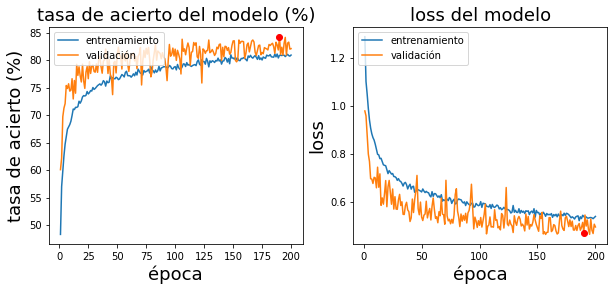

In [ ]:
epochs = 50

modelpath="best_model08.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
!ls -la

In [ ]:
modelpath="best_model07.h5"

In [ ]:
model_2 = load_model(modelpath)

## **Resultados obtenidos**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

614/614 [==============================] - 54s 87ms/step - loss: 0.4950 - accuracy: 0.8297
Train loss    : 0.49495479464530945
Train accuracy: 0.8297027945518494

264/264 [==============================] - 5s 18ms/step - loss: 0.4929 - accuracy: 0.8349
Val loss    : 0.4928937554359436
Val accuracy: 0.834916889667511

188/188 [==============================] - 3s 18ms/step - loss: 0.4947 - accuracy: 0.8343
Test loss     : 0.49472132325172424
Test accuracy : 0.8343333601951599


In [ ]:
scores_tr = model_2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model_2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model_2.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

614/614 [==============================] - 55s 90ms/step - loss: 0.5008 - accuracy: 0.8255
Train loss    : 0.5007582306861877
Train accuracy: 0.8255293369293213

264/264 [==============================] - 5s 17ms/step - loss: 0.4729 - accuracy: 0.8425
Val loss    : 0.47289708256721497
Val accuracy: 0.8425177931785583

188/188 [==============================] - 3s 17ms/step - loss: 0.4746 - accuracy: 0.8363
Test loss     : 0.47460848093032837
Test accuracy : 0.8363333344459534


In [ ]:
y_real = test_generator.classes
y_pred_proba = model_2.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
y_pred = np.argmax(y_pred_proba, axis=1)

In [ ]:
y_pred.shape

(3000,)

In [ ]:
y_real.shape

(3000,)

In [ ]:
y_pred_proba[:5]

array([[8.0786037e-01, 1.3339812e-03, 3.0209711e-02, 2.9485233e-02,
        1.1403959e-01, 1.7071133e-02],
       [9.2708701e-01, 1.8990559e-03, 1.0834332e-02, 2.8477937e-03,
        6.6108541e-03, 5.0720930e-02],
       [7.9061270e-01, 4.6869912e-03, 1.8569656e-02, 7.1533541e-03,
        4.9850158e-02, 1.2912713e-01],
       [3.8747251e-01, 5.0603244e-02, 4.2833094e-02, 3.4796044e-02,
        1.3550273e-01, 3.4879231e-01],
       [1.0320627e-01, 1.6864793e-05, 2.2660496e-03, 1.4361848e-02,
        8.7353718e-01, 6.6117248e-03]], dtype=float32)

In [ ]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import itertools

In [ ]:
cm = confusion_matrix(y_real, y_pred, normalize='true')
cm

array([[0.84439359, 0.00686499, 0.00457666, 0.00686499, 0.0228833 ,
        0.11441648],
       [0.00632911, 0.96835443, 0.        , 0.01054852, 0.0021097 ,
        0.01265823],
       [0.02350814, 0.00361664, 0.75406872, 0.16274864, 0.04159132,
        0.01446655],
       [0.03238095, 0.00190476, 0.10666667, 0.77714286, 0.07809524,
        0.00380952],
       [0.04313725, 0.00392157, 0.04901961, 0.02941176, 0.85294118,
        0.02156863],
       [0.13373253, 0.00798403, 0.00199601, 0.00798403, 0.00798403,
        0.84031936]])

In [ ]:
target_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

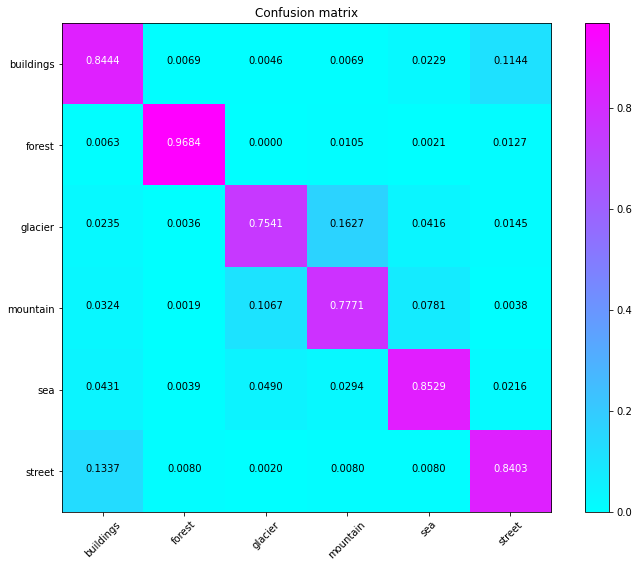

In [ ]:
plt.figure(figsize=(12,9))
plt.imshow(cm, cmap='cool')
plt.colorbar()
plt.title('Confusion matrix')


tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > 0.5 else "black")


plt.show()

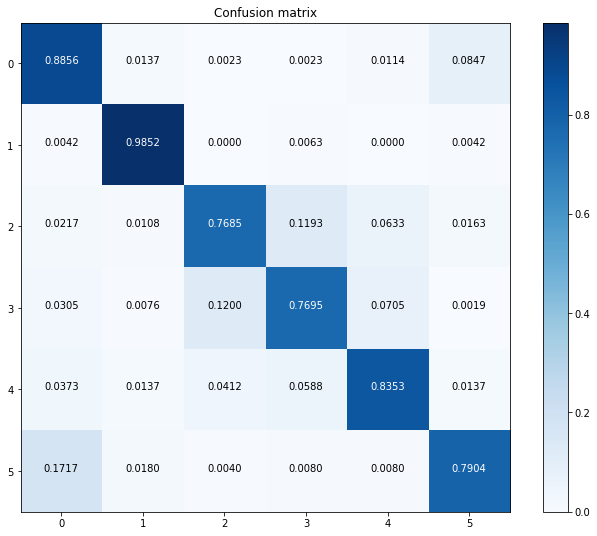

In [ ]:
plt.figure(figsize=(12,9))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion matrix')

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > 0.5 else "black")


plt.show()

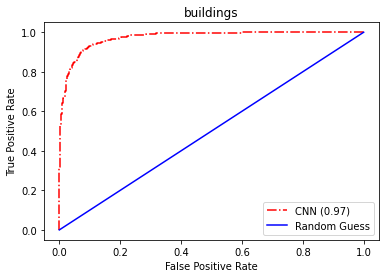

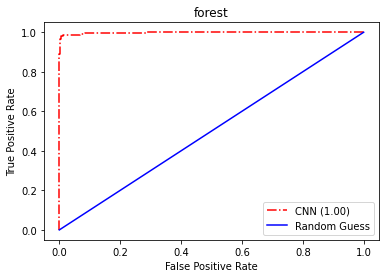

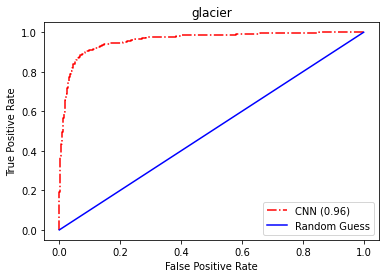

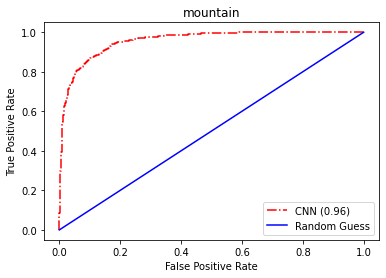

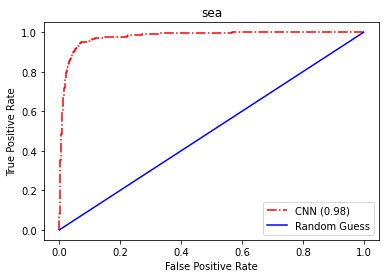

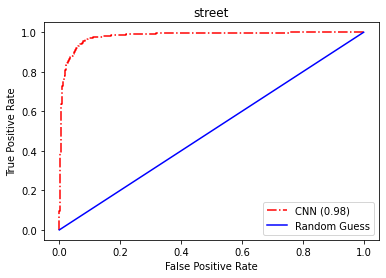

In [ ]:
for clase in range(6):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()

## **Visualización de ejemplos de test**

In [ ]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

Found 3000 images belonging to 6 classes.


In [ ]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [ ]:
test_generator2.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
y_te

array([0., 0., 0., ..., 5., 5., 5.], dtype=float32)

Clase real: mountain
buildings: 0% forest: 0% glacier: 5% mountain: 93% sea: 0% street: 0% 


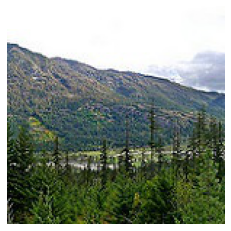

In [ ]:
ind_te1 = 1500

image = X_te[ind_te1].copy()

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]
cadena = ""
for i in range(len(num2class)):
    cadena = cadena + "{}: {}% ".format(num2class[i], int(100*p[i]))
print(cadena)

In [ ]:
!ls

best_model02.h5  best_model.h5	sample_data  seg_test.zip  seg_train.zip
best_model03.h5  __MACOSX	seg_test     seg_train


In [ ]:
# Para descargar el modelo a local:

#from google.colab import files
#files.download('./best_model.h5')